# Interpolation with Units

The interpolation algorithms within `opticks` use piecewise polynomials to interpolate discrete data. The underlying library is of course `scipy`, which offers Cubic Spline based as well as monotone interpolators. The latter prevents overshoot but may be less accurate locally, particularly for smooth data.

Unlike `numpy`, the units library `astropy.units` does not directly support `scipy`. Therefore the unit support for the interpolators had to be defined from scratch.

For this, `PPolyWithUnits` and `InterpolatorWithUnits` are developed, mimicking the relationship between `scipy` class `.PPoly` and interpolators like `CubicHermiteSpline`.

We have to start with the opticks package import as well as some other useful packages.

In [26]:
# If opticks import fails, try to locate the module
# This can happen building the docs
import os

try:
    import opticks
except ModuleNotFoundError:
    os.chdir(os.path.join("..", "..", ".."))
    os.getcwd()

In [27]:
import numpy as np

from opticks import u

from astropy.visualization import quantity_support

# astropy units support for matplotlib
quantity_support()

%matplotlib inline

from matplotlib import pyplot as plt

import warnings

warnings.filterwarnings("always")

First we can check whether the scipy interpolators really ignore units with a simple example. We will create a quadratic polynomial with the units of time and distance.

$$ y(t) = (t-2)(t+3) = t^2 + t- 6 $$

This form shows the roots clearly, which will be useful later. The interpolator is set up from discrete points between -10 sec and +10 sec.

The derivative is simply:

$$ \dot{y}(t) = 2t + 1 $$

And the integral is:

$$ \int y dt =  \frac{t^3}{3} + \frac{t^2}{2}- 6t + C $$

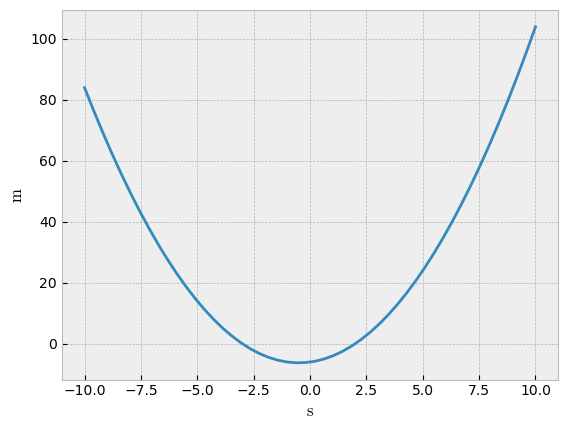

In [28]:
import matplotlib.pyplot as plt
from scipy.interpolate import Akima1DInterpolator

# define the polynomial with discrete samples
t = np.linspace(-10, 10, endpoint=True) * u.s
y = (t.value - 2) * (t.value + 3) * u.m

# set plot style
plt.style.use("bmh")

# plot the data for easy visualisation
plt.plot(t, y)

In [29]:
# prepare interpolator (causes UnitStrippedWarning)
ipl_no_units = Akima1DInterpolator(t, y, method="akima")

# interpolation target value
t_tgt = 4.1 * u.s

# result should be in m
print(ipl_no_units(t_tgt))

# same input time in minutes - the result should have been the same
print(ipl_no_units(t_tgt.to(u.min)))

14.909999999999997
-5.926997222222222


Two observations can be made: While the inputs have units, the result of the interpolation has no units, which resulted in a difference when the same time is expressed in minutes. And we received a `UnitStrippedWarning` that explains why; there is a downcasting within the interpolation that deletes the units.

On the other hand, the numpy linear interpolation works out of the box.

In [30]:
print(np.interp(t_tgt, t, y))

14.951311953352768 m


Now try the new `InterpolatorWithUnits`.

In [31]:
from opticks.utils.math_utils import InterpolatorWithUnits, InterpolatorWithUnitTypes

# choose the interpolator type
ipol_type = InterpolatorWithUnitTypes.AKIMA

# init the interpolator
ipol = InterpolatorWithUnits.from_ipol_method(ipol_type, t, y, extrapolate=True)

# result should be in m
print(ipol(t_tgt))

# same input time in minutes - the result should be the same
print(ipol(t_tgt.to(u.min)))

# exact value
print((t_tgt.value - 2) * (t_tgt.value + 3) * u.m)

14.909999999999997 m
14.909999999999997 m
14.909999999999997 m


The initialisation is the same as the standard `Akima1DInterpolator`, accepting all the `args` and `kwargs` necessary, with the exception of `method` keyword for Akima - the `InterpolatorWithUnitTypes.MAKIMA` takes care of this by initialising a Modified Akima scheme.

The other thing to note is that the unit conversions are handled automatically. It does not matter whether the input is given in seconds or minutes, the result is the same in both cases.

However, the unit checks are strict. For example, if the unit of the interpolation target `t_tgt` does not match the unit of the `t` values, an exception will be thrown. Similarly, a float would not be accepted in this case, as there is no way to know how to interpret a float - is it in seconds or hours?

Other functions from the `scipy` interpolators are also implemented.

In [32]:
deriv = ipol.derivative(1)
print(f"Derivative: {deriv(t_tgt)}")
print(f"Derivative: {(2 * t_tgt.value + 1) * u.m / u.s} (exact value)")


antideriv = ipol.antiderivative(1)
print(f"Antiderivative: {antideriv(t_tgt):.6}")
# this is essentially the definite integral from t_begin to t_tgt
t_begin = t[0]
int_begin = ((t_begin.value**3 / 3) + (t_begin.value**2 / 2) - 6 * t_begin.value) * u.m * u.s
int_tgt = ((t_tgt.value**3 / 3) + (t_tgt.value**2 / 2) - 6 * t_tgt.value) * u.m * u.s
print(f"Antiderivative: {int_tgt - int_begin:.6} (exact value)")


a = -1 * u.s
b = 4.1 * u.s
print(f"Definite Integral from {a} to {b}: {ipol.integrate(a, b):.6}")
int_begin = ((a.value**3 / 3) + (a.value**2 / 2) - 6 * a.value) * u.m * u.s
int_tgt = ((b.value**3 / 3) + (b.value**2 / 2) - 6 * b.value) * u.m * u.s
print(
    f"Definite Integral from {a} to {b}: {int_tgt - int_begin} (exact value)"
)

print("--------")

solve_tgt = 20 * u.m
print(f"Solve at {solve_tgt}: {ipol.solve(solve_tgt)}")

print(f"Roots : {ipol.roots()}")

Derivative: 9.2 m / s
Derivative: 9.2 m / s (exact value)
Antiderivative: 230.112 m s
Antiderivative: 230.112 m s (exact value)
Definite Integral from -1.0 s to 4.1 s: 0.612 m s
Definite Integral from -1.0 s to 4.1 s: 0.6119999999999957 m s (exact value)
--------
Solve at 20.0 m: [-5.62347538  4.62347538] s
Roots : [-3.  2.] s


Also note that the `antiderivative` is from the beginning of the x axis data (in this case -10 seconds) until the requested point (in this case `t_tgt`). `integrate` is similar, but the beginning and end points are explicitly defined.

The other way to initialise the `InterpolatorWithUnits` is to ingest an external interpolator and add units. That said, units are not strictly required.

We can show both in an example.

In [33]:
# Init scipy interpolator, strip units
scipy_ipol = Akima1DInterpolator(t.value, y.value, method="makima")

# Init the Interpolator with units, but delete the units of y
ipol2 = InterpolatorWithUnits(scipy_ipol, t.unit, None)

# result should be without dimensions
print(ipol2(t_tgt))

14.910166202386884


Finally, let's see how another interpolator can be initialised with `args` and `kwargs` passed on properly.

In [34]:
# Array containing derivatives of the dependent variable.
# Set with zeros, probably not realistic, but ok for this example
dydx = np.zeros_like(t)

ipol3 = InterpolatorWithUnits.from_ipol_method(
    InterpolatorWithUnitTypes.CUBICHERMITESPL, t, y, dydx=dydx
)
print(ipol3(t_tgt), InterpolatorWithUnitTypes.CUBICHERMITESPL.name)


ipol4 = InterpolatorWithUnits.from_ipol_method(
    InterpolatorWithUnitTypes.CUBICSPL, t, y, bc_type="not-a-knot"
)

print(ipol4(t_tgt), InterpolatorWithUnitTypes.CUBICSPL.name)

15.034782755102038 m CUBICHERMITESPL
14.909999999999997 m CUBICSPL
